In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [2]:
class FingerPrint:
    def __init__(self, path_image) -> None:
        self.image = cv.imread(path_image, cv.IMREAD_GRAYSCALE)
        self.window_size = 20
        self.norm_image = None
        self.grad_x = None
        self.grad_y = None
        self.core_points = None
        self.core_point = None
        self.visual_core_points = None
        self.orientation_map = None
        self.cropped_image = None

    def process(self):
        self.norm_image = self.normalization(self.image)
        self.grad_x = self.gradient_x(self.norm_image)
        self.grad_y = self.gradient_y(self.norm_image)
        self.orientation_map, self.core_points, self.visual_core_points = self.orientation_estimation_field(self.norm_image, self.grad_x, self.grad_y, self.window_size)
        self.core_point = self.optimal_core_point(self.core_points)
        self.cropped_image = self.crop_image(self.norm_image, self.core_point)

    def get_cropped_image_with_optimal_core_point(self):
        return self.cropped_image

    def normalization(self, image):
        rows, cols = image.shape[0], image.shape[1]

        desired_mean = 150
        desired_variance = 150
        image_mean = np.mean(image)
        image_variance = np.var(image)
        normalized_image = np.zeros_like(image)

        for i in range(rows):
            for j in range(cols):
                if image[i, j] > image_mean:
                    normalized_image[i, j] = desired_mean + np.sqrt((desired_variance * np.square(image[i, j] - image_mean)) / image_variance)
                else:
                    normalized_image[i, j] = desired_mean - np.sqrt((desired_variance * np.square(image[i, j] - image_mean)) / image_variance)
        
        return normalized_image
    
    def gradient_x(self, norm_image):
        return cv.Sobel(norm_image, cv.CV_64F, 1, 0, ksize=3)
    
    def gradient_y(self, norm_image):
        return cv.Sobel(norm_image, cv.CV_64F, 0, 1, ksize=3)
    
    def local_orientation_estimation(self, grad_x, grad_y, i, j, window_size):
        V_x = 0
        V_y = 0
        for u in range(window_size):
            for v in range(window_size):
                V_x += 2 * grad_x[i + u, j + v] * grad_y[i + u, j + v]
                V_y += (grad_x[i + u, j + v] ** 2) * (grad_y[i + u, j + v] ** 2)
        
        return V_x, V_y
    

    def curvature_technique(self, block_orientation, window_size):
        diff_x = 0
        diff_y = 0
        for i in range(window_size):
            diff_x += np.cos(2 * block_orientation[window_size - 1, i]) - np.cos(2 * block_orientation[0, i])
            diff_y += np.sin(2 * block_orientation[i, window_size - 1]) - np.sin(2 * block_orientation[i, 0])
        
        return diff_x, diff_y
    
    def orientation_estimation_field(self, norm_image, grad_x, grad_y, window_size):
        '''
        Pizdec karoche tyta
        '''
        rows, cols = norm_image.shape[0], norm_image.shape[1]
        orientation_map = np.zeros((rows, cols))
        
        core_points = []
        # orientation_blocks = []
        visual_core_points = np.zeros((rows - window_size, cols - window_size))

        for i in range(0, rows - window_size * 2 , window_size):
            for j in range(0, cols - window_size * 2 , window_size):
                block_orientation = np.zeros((window_size, window_size))

                for k in range(window_size):
                    for m in range(window_size):
                        V_x, V_y = self.local_orientation_estimation(grad_x, grad_y, i + k, j + m, window_size)
                        
                        if V_x == 0:
                            block_orientation[k, m] = 0
                        else:
                            block_orientation[k, m] = 0.5 * np.arctan(V_y / V_x)

                # orientation_blocks.append(block_orientation)
                orientation_map[i:i+window_size, j:j+window_size] = block_orientation

                diff_x, diff_y = self.curvature_technique(block_orientation, window_size)

                if diff_x < 0 and diff_y < 0:
                    visual_core_points[i, j] = 255
                    core_points.append((i + window_size // 2, j + window_size // 2))
        
        return orientation_map, core_points, visual_core_points
    
    def euclidian_dist(self, point_1, point_2):
        x_1, y_1 = point_1
        x_2, y_2 = point_2

        return ((x_2 - x_1) ** 2 + (y_2 - y_1) ** 2) * 0.5
    
    def optimal_core_point(self, core_points):
        total_distances = {}
        for core_point_1 in core_points:
            distance = 0
            for core_point_2 in core_points:
                distance += self.euclidian_dist(core_point_1, core_point_2)
            total_distances[core_point_1] = distance
        
        return min(total_distances, key=total_distances.get)

    def crop_image(self, norm_image, core_point):
        img_height, img_width = norm_image.shape
        crop_size = 100

        # Calculate the coordinates for cropping
        left = max(0, core_point[0] - crop_size // 2)
        upper = max(0, core_point[1] - crop_size // 2)
        right = min(img_width, left + crop_size)
        lower = min(img_height, upper + crop_size)

        # Ensure the cropped region is centered around the core point
        if right - left < crop_size:
            # Adjust right boundary
            right = min(img_width, core_point[0] + crop_size // 2)

            # Adjust left boundary to maintain crop_size
            left = max(0, right - crop_size)

        if lower - upper < crop_size:
            # Adjust lower boundary
            lower = min(img_height, core_point[1] + crop_size // 2)

            # Adjust upper boundary to maintain crop_size
            upper = max(0, lower - crop_size)

        # Perform cropping
        cropped_img = norm_image[upper:lower, left:right]
        return cropped_img
        
    def show_original_image(self):
        plt.figure(figsize=(12, 6))

        plt.imshow(self.image, cmap='gray')
        plt.title('Original image')
        plt.axis('off')

        plt.show()

    def show_grad_x(self):
        plt.figure(figsize=(12, 6))

        plt.imshow(self.grad_x, cmap='gray')
        plt.title('Gradient X')
        plt.axis('off')

        plt.show()

    def show_grad_y(self):
        plt.figure(figsize=(12, 6))

        plt.imshow(self.grad_y, cmap='gray')
        plt.title('Gradient Y')
        plt.axis('off')
        
        plt.show()

    def show_normalized_image(self):
        cv.imshow('Normalized Image', self.norm_image)
        cv.waitKey(0)
        cv.destroyAllWindows()

    def show_potential_core_points(self):
        
        plt.figure(figsize=(12, 6))

        for coords in self.core_points:
            plt.scatter(coords[0], coords[1], color='red', marker='o', s=50)

        plt.imshow(self.norm_image, cmap='gray')
        plt.title('Potential core points')
        plt.axis('off')
        
        plt.show()

    def show_estimated_orientation_field(self): # не дуже корисно, можна потім видалити
        
        plt.figure(figsize=(12, 6))

        plt.imshow(self.orientation_map, cmap='gray')
        plt.title('Orientation field')
        plt.axis('off')
        
        plt.show()

    def show_optimal_core_point(self):

        plt.figure(figsize=(12, 6))

        plt.scatter(self.core_point[0], self.core_point[1], color='green', marker='o', s=50)  

        plt.imshow(self.norm_image, cmap='gray')
        plt.title('Optimal core point')
        plt.axis('off')
        
        plt.show()

    def show_core_points_with_optimal_core_point(self):
        plt.figure(figsize=(12, 6))

        for coords in self.core_points:
            plt.scatter(coords[0], coords[1], color='red', marker='o', s=50) 

        plt.scatter(self.core_point[0], self.core_point[1], color='green', marker='o', s=50)  

        
        plt.title('Core points')
        plt.legend(handles=[
        mpatches.Patch(color='red', label='Potential core points'),
        mpatches.Patch(color='green', label='Optimal core point')
                            ])
        plt.axis('off')
        plt.imshow(self.norm_image, cmap='gray')
        plt.show()

    def show_cropped_image(self):

        plt.figure(figsize=(12, 6))
        plt.imshow(self.cropped_image, cmap='gray')
        plt.title('Cropped image')
        plt.axis('off')
        
        plt.show()
        

In [41]:
finger = FingerPrint('11.jpg')
finger.process()

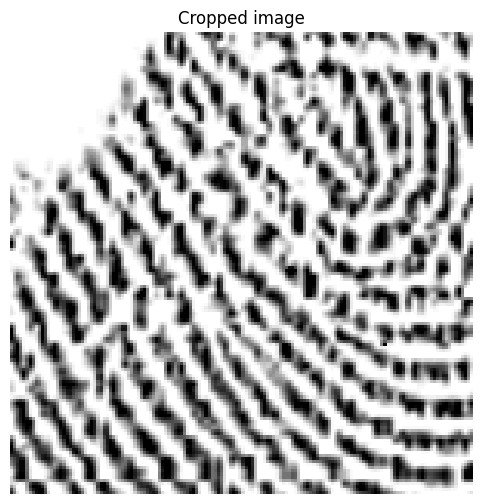

In [42]:
finger.show_cropped_image()

In [3]:
def process_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for root, dirs, files in os.walk(input_folder):
        for subfolder in dirs:
            subfolder_path = os.path.join(root, subfolder)
            output_subfolder = os.path.join(output_folder, subfolder)

            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)

            for file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, file)
                fingerprint = FingerPrint(image_path)
                fingerprint.process()
                cropped_image = fingerprint.get_cropped_image_with_optimal_core_point()
                output_image = os.path.join(output_subfolder, f'norm_cropped_{file}')
                cv.imwrite(output_image, cropped_image)


In [4]:
process_images('data', 'processed_data')

In [5]:
def normalization(image):
    rows, cols = image.shape[0], image.shape[1]

    desired_mean = 150
    desired_variance = 150
    image_mean = np.mean(image)
    image_variance = np.var(image)
    normalized_image = np.zeros_like(image)

    for i in range(rows):
        for j in range(cols):
            if image[i, j] > image_mean:
                normalized_image[i, j] = desired_mean + np.sqrt((desired_variance * np.square(image[i, j] - image_mean)) / image_variance)
            else:
                normalized_image[i, j] = desired_mean - np.sqrt((desired_variance * np.square(image[i, j] - image_mean)) / image_variance)
    
    return normalized_image
    

In [6]:
def gradient_x(image):
    return cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)

In [7]:
def gradient_y(image):
    return cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)

In [8]:
def local_orientation_estimation(grad_x, grad_y, i, j, window_size):
    V_x = 0
    V_y = 0
    for u in range(window_size):
        for v in range(window_size):
            V_x += 2 * grad_x[i + u, j + v] * grad_y[i + u, j + v]
            V_y += (grad_x[i + u, j + v] ** 2) * (grad_y[i + u, j + v] ** 2)
    
    return V_x, V_y


In [9]:
def curvature_technique(block_orientation, window_size):
    diff_x = 0
    diff_y = 0
    for i in range(window_size):
        diff_x += np.cos(2 * block_orientation[window_size - 1, i]) - np.cos(2 * block_orientation[0, i])
        diff_y += np.sin(2 * block_orientation[i, window_size - 1]) - np.sin(2 * block_orientation[i, 0])
    
    return diff_x, diff_y


In [10]:
def orientation_estimation_field(image, grad_x, grad_y, window_size):
    '''
    Pizdec karoche tyta
    '''
    rows, cols = image.shape[0], image.shape[1]
    orientation_map = np.zeros((rows, cols))
    
    core_points = []
    orientation_blocks = []
    visual_core_points = np.zeros((rows - window_size, cols - window_size))

    for i in range(0, rows - window_size * 2 , window_size):
        for j in range(0, cols - window_size * 2 , window_size):
            block_orientation = np.zeros((window_size, window_size))

            for k in range(window_size):
                for m in range(window_size):
                    V_x, V_y = local_orientation_estimation(grad_x, grad_y, i + k, j + m, window_size)
                    
                    if V_x == 0:
                        block_orientation[k, m] = 0
                    else:
                        block_orientation[k, m] = 0.5 * np.arctan(V_y / V_x)

            orientation_blocks.append(block_orientation)
            orientation_map[i:i+window_size, j:j+window_size] = block_orientation

            diff_x, diff_y = curvature_technique(block_orientation, window_size)

            if diff_x < 0 and diff_y < 0:
                visual_core_points[i, j] = 255
                core_points.append((i + window_size // 2, j + window_size // 2))



    return orientation_map, orientation_blocks, core_points, visual_core_points
                

In [11]:
def euclidian_dist(point_1, point_2):
    x_1, y_1 = point_1
    x_2, y_2 = point_2

    return ((x_2 - x_1) ** 2 + (y_2 - y_1) ** 2) * 0.5

In [12]:
def optimal_core_point(core_points):
    total_distances = {}
    for core_point_1 in core_points:
        distance = 0
        for core_point_2 in core_points:
            distance += euclidian_dist(core_point_1, core_point_2)
        total_distances[core_point_1] = distance
    
    return min(total_distances, key=total_distances.get)

In [13]:
def crop_image(norm_image, core_point):
    img_height, img_width = norm_image.shape
    crop_size = 150
    # Calculate the coordinates for cropping
    left = max(0, core_point[0] - crop_size // 2)
    upper = max(0, core_point[1] - crop_size // 2)
    right = min(img_width, core_point[0] + crop_size // 2)
    lower = min(img_height, core_point[1] + crop_size // 2)

    cropped_img = norm_image[upper:lower, left:right]
    return cropped_img



In [14]:
# image = cv.imread('12.jpg', cv.IMREAD_GRAYSCALE)
# norm_image = normalization(image=image)

# grad_x = gradient_x(norm_image)
# grad_y = gradient_y(norm_image)

# window_size = 20

# orientation_map, blocks, core_points, visual_core_points = orientation_estimation_field(norm_image, grad_x, grad_y, window_size)

# # cv.imshow('Normalized Image', orientation_map)
# # cv.waitKey(0)
# # cv.destroyAllWindows()


In [15]:
# core_point = optimal_core_point(core_points)

# cropped = crop_image(norm_image, core_point)

# # Plot the image
# # Plot the image
# plt.imshow(cropped, cmap='gray')

# # Plot the blue dots for core points
# for coords in core_points:
#     plt.scatter(coords[0], coords[1], color='red', marker='o', s=50)  # Corrected

# # Plot the optimal core point as a red dot
# plt.scatter(core_point[0], core_point[1], color='green', marker='o', s=50)  

# plt.show()

In [16]:
plt.imshow(visual_core_points, cmap='gray')
plt.title('core points')
plt.axis('off')
plt.show()

NameError: name 'visual_core_points' is not defined

(-0.5, 199.5, 199.5, -0.5)

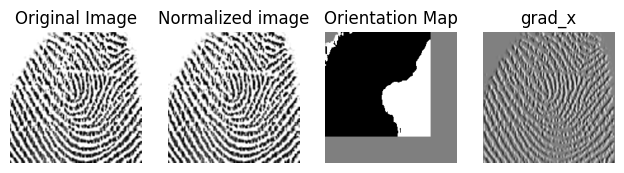

In [ ]:
plt.figure(figsize=(20, 12))

# Original Image
plt.subplot(1, 10, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')


plt.subplot(1, 10, 2)
plt.imshow(norm_image, cmap='gray')
plt.title('Normalized image')
plt.axis('off')

# Orientation Map
plt.subplot(1, 10, 3)
plt.imshow(orientation_map, cmap='gray')
plt.title('Orientation Map')
plt.axis('off')


# Orientation Map
plt.subplot(1, 10, 4)
plt.imshow(grad_x, cmap='gray')
plt.title('grad_x')
plt.axis('off')



